## Importing features

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_style('darkgrid')

## Reading States Dict

In [3]:
states_dict = {
        'AK': ['Alaska', 3],
        'AL': ['Alabama', 9],
        'AR': ['Arkansas', 6],
        'AZ': ['Arizona', 11],
        'CA': ['California', 55],
        'CO': ['Colorado', 9],
        'CT': ['Connecticut', 7],
        'DC': ['District of Columbia', 3],
        'DE': ['Delaware', 3],
        'FL': ['Florida', 29],
        'GA': ['Georgia', 16],
        'HI': ['Hawaii', 4],
        'IA': ['Iowa', 6],
        'ID': ['Idaho', 4],
        'IL': ['Illinois', 20],
        'IN': ['Indiana', 11],
        'KS': ['Kansas', 6],
        'KY': ['Kentucky', 8],
        'LA': ['Louisiana', 8],
        'MA': ['Massachusetts', 11],
        'MD': ['Maryland', 10],
        'ME': ['Maine', 4],
        'MI': ['Michigan', 16],
        'MN': ['Minnesota', 10],
        'MO': ['Missouri', 10],
        'MS': ['Mississippi', 6],
        'MT': ['Montana', 3],
        'NC': ['North Carolina', 15],
        'ND': ['North Dakota', 3],
        'NE': ['Nebraska', 5],
        'NH': ['New Hampshire', 4],
        'NJ': ['New Jersey', 14],
        'NM': ['New Mexico', 5],
        'NV': ['Nevada', 6],
        'NY': ['New York', 29],
        'OH': ['Ohio', 18],
        'OK': ['Oklahoma', 7],
        'OR': ['Oregon', 7],
        'PA': ['Pennsylvania', 20],
        'RI': ['Rhode Island', 4],
        'SC': ['South Carolina', 9],
        'SD': ['South Dakota', 3],
        'TN': ['Tennessee', 11],
        'TX': ['Texas' ,38],
        'UT': ['Utah', 6],
        'VA': ['Virginia', 13],
        'VT': ['Vermont', 3],
        'WA': ['Washington', 12],
        'WI': ['Wisconsin', 10],
        'WV': ['West Virginia', 5],
        'WY': ['Wyoming', 3]
}
states = pd.DataFrame.from_dict(states_dict, orient='index').reset_index()
states.columns = ['state_abbr', 'state', 'ev']


## Reading 2016 election voting data

In [4]:
election2016 = pd.read_csv('../data/raw/1976-2016-president.csv', usecols=['year', 'state_po', 'party', 'candidatevotes',])
election2016 = election2016[election2016['year'] == 2016]
election2016 = election2016[(election2016['party'] == 'democrat') | (election2016['party'] == 'republican')  ]
election2016 = election2016.groupby(['state_po', 'party']).sum().reset_index()
election2016 = election2016.pivot_table(index = 'state_po', columns = 'party', values = 'candidatevotes').reset_index()
election2016['two_party_sum'] = election2016['democrat'] + election2016['republican']
election2016['dem_perc'] = election2016['democrat']/ election2016['two_party_sum']
election2016['rep_perc'] = election2016['republican']/ election2016['two_party_sum']
election2016 = election2016[['state_po', 'dem_perc', 'rep_perc']]
election2016.columns = ['state_abbr', 'dem_perc', 'rep_perc']
election2016 = election2016.merge(states, on = 'state_abbr', how = 'left')

In [5]:
election2016.head()

,state_abbr,dem_perc,rep_perc,state,ev
0,AK,0.416143,0.583857,Alaska,3
1,AL,0.356259,0.643741,Alabama,9
2,AR,0.357149,0.642851,Arkansas,6
3,AZ,0.481109,0.518891,Arizona,11
4,CA,0.661282,0.338718,California,55


## 2020 polls data

In [6]:
def calculate_moe(row):
    z = 1.96
    p = row['dem_perc']
    n = row['sample_size']
    moe = z*np.sqrt(p*(1-p)/n)
    return moe


def average_error(nobs, p=0.5):
    return p*nobs**-.5

In [7]:
pollster_map = {'A': 0.9, 'B' : 0.8, 'C' : 0.7, 'D' : 0.6}
poll2020 = pd.read_csv('../data/raw/president_polls2.csv', parse_dates=['start_date'], 
                  usecols=['state', 'pollster', 'sample_size', 'start_date',  'candidate_party', 'pct', 'fte_grade'])
poll2020['fte_grade'] = poll2020['fte_grade'].str.replace(r'[+-]|\/\w', '')
poll2020['fte_grade'] = poll2020['fte_grade'].map(pollster_map )
poll2020['fte_grade'] = poll2020['fte_grade'].fillna(poll2020.fte_grade.mode().item())

In [8]:
pollster_map = {'A': 0.9, 'B' : 0.8, 'C' : 0.7, 'D' : 0.6}
poll2020 = pd.read_csv('../data/raw/president_polls2.csv', parse_dates=['start_date'], 
                  usecols=['state', 'pollster', 'sample_size', 'start_date',  'candidate_party', 'pct', 'fte_grade'])

poll2020['fte_grade'] = poll2020['fte_grade'].str.replace(r'[+-]|\/\w', '')
poll2020['fte_grade'] = poll2020['fte_grade'].map(pollster_map )
poll2020['fte_grade'] = poll2020['fte_grade'].fillna(poll2020.fte_grade.mode().item())
# poll2020['fte_grade'] = poll2020['fte_grade']-poll2020['fte_grade'].mean()
poll2020['pct'] = poll2020['pct']*poll2020['fte_grade']
poll2020['ae'] = poll2020['sample_size'].apply(average_error)
poll2020 = poll2020[(poll2020.candidate_party == 'DEM') | (poll2020.candidate_party == 'REP')  ]
poll2020 = poll2020[poll2020['start_date'] > '2018-12-31']
poll2020['state'] = poll2020['state'].fillna('USA')
# pollusa = poll2020[poll2020['state'] != 'USA']

pollusa = poll2020.copy()
pollusa = poll2020.pivot_table(index = ['start_date', 'state', 'sample_size', 'fte_grade', 'ae'], columns = ['candidate_party'],
                    values = 'pct' , aggfunc = np.mean).reset_index().groupby([pd.Grouper(key='start_date', freq='M'), 'state'])


pollusa = pollusa.mean().reset_index()
pollusa['two_party_sum'] = pollusa['DEM'] + pollusa['REP']
pollusa['dem_perc'] = pollusa['DEM'] / pollusa['two_party_sum']
pollusa['rep_perc'] = pollusa['REP'] / pollusa['two_party_sum']
pollusa['moe'] = pollusa.apply(calculate_moe, axis=1) + pollusa['ae']
# pollusa['ae'] = pollusa['sample_size'].apply(average_error)
pollusa = pollusa.drop(['DEM', 'REP', 'two_party_sum', 'ae', 'sample_size', 'fte_grade' ], axis=1)
pollusa = pollusa.round(2)

In [9]:
pollusa.tail(20)

candidate_party,start_date,state,dem_perc,rep_perc,moe
269,2020-07-31,Iowa,0.50,0.50,0.05
270,2020-07-31,Kentucky,0.40,0.60,0.05
271,2020-07-31,Maine,0.56,0.44,0.05
272,2020-07-31,Maine CD-1,0.61,0.39,0.07
273,2020-07-31,Maine CD-2,0.52,0.48,0.07
274,2020-07-31,Massachusetts,0.71,0.29,0.05
275,2020-07-31,Michigan,0.54,0.46,0.05
276,2020-07-31,Minnesota,0.54,0.46,0.05
277,2020-07-31,Montana,0.46,0.54,0.05
278,2020-07-31,New Hampshire,0.57,0.43,0.03


In [10]:
# pollusa_std = poll2020.pivot_table(index = ['start_date', 'state'], columns = ['candidate_party'],
#                     values = 'pct' , aggfunc = np.std).reset_index().groupby([pd.Grouper(key='start_date', freq='M'), 'state'])

# pollusa_std = (pollusa_std.mean()/100).round(4).reset_index()
# pollusa_std.columns = ['start_date', 'state', 'dem_std', 'rep_std']

In [11]:
# pollusa = pollusa.merge(pollusa_std, on=['start_date', 'state'], how = 'inner')

In [12]:
national = pollusa[pollusa['state'] == 'USA']
national

candidate_party,start_date,state,dem_perc,rep_perc,moe
5,2019-01-31,USA,0.50,0.50,0.05
12,2019-02-28,USA,0.53,0.47,0.05
17,2019-03-31,USA,0.50,0.50,0.03
26,2019-04-30,USA,0.50,0.50,0.04
35,2019-05-31,USA,0.50,0.50,0.03
44,2019-06-30,USA,0.51,0.49,0.04
56,2019-07-31,USA,0.51,0.49,0.04
67,2019-08-31,USA,0.52,0.48,0.04
81,2019-09-30,USA,0.53,0.47,0.04
99,2019-10-31,USA,0.53,0.47,0.04


In [13]:
monthly = pollusa['start_date'].unique()

In [14]:
dfs = [election2016]
for m in monthly:
    dfs.append(pollusa[pollusa['start_date'] == m])

for i in range(1,len(dfs)):
    if i==1:
        dfs[i] = dfs[i].merge(dfs[i-1], on = ['state'], how = 'right', indicator=True)
        dfs[i]['start_date'] = dfs[i]['start_date'].fillna(dfs[i]['start_date'][0])
        dfs[i]['dem_perc_x'] = dfs[i]['dem_perc_x'].fillna(dfs[i]['dem_perc_y'])
        dfs[i]['rep_perc_x'] = dfs[i]['rep_perc_x'].fillna(dfs[i]['rep_perc_y'])

#         dfs[i]['dem_std'] = dfs[i]['dem_std'].fillna(national['dem_std'].iloc[i-1])
#         dfs[i]['rep_std'] = dfs[i]['rep_std'].fillna(national['rep_std'].iloc[i-1])
        dfs[i]['moe'] = dfs[i]['moe'].fillna(national['moe'].iloc[i-1])

        dfs[i] = dfs[i].drop(['dem_perc_y', 'rep_perc_y', '_merge'], axis=i)

        dfs[i].columns = ['start_date', 'state', 'dem_perc', 'rep_perc', 'moe', 'state_abbr', 'ev']
        dfs[i][['dem_perc', 'rep_perc']] = dfs[i][['dem_perc', 'rep_perc']].round(2)
        dfs[i] = dfs[i].sort_values(by = 'state').reset_index(drop=True)
#         dfs[i]['dem_std'] = dfs[i].apply(lambda x: x['rep_std'] if x['dem_std'] < 0.0001 else x['dem_std'], axis=1)
#         dfs[i]['rep_std'] = dfs[i].apply(lambda x: x['dem_std'] if x['rep_std'] < 0.0001 else x['rep_std'], axis=1)
        
    else:
        
        dfs[i] = dfs[i].merge(dfs[i-1], on = ['state'], how = 'right', indicator=True)
        dfs[i]['start_date_x'] = dfs[i]['start_date_x'].fillna(dfs[i]['start_date_x'][0])
        dfs[i]['dem_perc_x'] = dfs[i]['dem_perc_x'].fillna(dfs[i]['dem_perc_y'])
        dfs[i]['rep_perc_x'] = dfs[i]['rep_perc_x'].fillna(dfs[i]['rep_perc_y'])

        dfs[i]['moe_x'] = dfs[i]['moe_x'].fillna(national['moe'].iloc[i-1])
#         dfs[i]['dem_std_x'] = dfs[i]['dem_std_x'].fillna(national['dem_std'].iloc[i-1])
#         dfs[i]['rep_std_x'] = dfs[i]['rep_std_x'].fillna(national['rep_std'].iloc[i-1])

        dfs[i] = dfs[i].drop(['start_date_y', 'dem_perc_y', 'rep_perc_y', 'moe_y', '_merge'], axis=1)

        dfs[i].columns = ['start_date', 'state', 'dem_perc', 'rep_perc', 'moe', 'state_abbr', 'ev']
        dfs[i][['dem_perc','rep_perc']] = dfs[i][['dem_perc','rep_perc']].round(2)
        dfs[i] = dfs[i].sort_values(by = 'state').reset_index(drop=True)
#         dfs[i]['dem_std'] = dfs[i].apply(lambda x: x['rep_std'] if x['dem_std'] < 0.0001 else x['dem_std'], axis=1)
#         dfs[i]['rep_std'] = dfs[i].apply(lambda x: x['dem_std'] if x['rep_std'] < 0.0001 else x['rep_std'], axis=1)              
               
dfs = dfs[1:]         


In [15]:
# dfs[1] = dfs[1].merge(dfs[0], on = ['state'], how = 'right', indicator=True)
# dfs[1]['start_date'] = dfs[1]['start_date'].fillna(dfs[1]['start_date'][0])
# dfs[1]['dem_perc_x'] = dfs[1]['dem_perc_x'].fillna(dfs[1]['dem_perc_y'])
# dfs[1]['rep_perc_x'] = dfs[1]['rep_perc_x'].fillna(dfs[1]['rep_perc_y'])

# dfs[1]['dem_std'] = dfs[1]['dem_std'].fillna(national['dem_std'].iloc[0])
# dfs[1]['rep_std'] = dfs[1]['rep_std'].fillna(national['rep_std'].iloc[0])

# dfs[1] = dfs[1].drop(['dem_perc_y', 'rep_perc_y', '_merge'], axis=1)

# dfs[1].columns = ['start_date', 'state', 'dem_perc', 'rep_perc', 'dem_std', 'rep_std', 'state_abbr', 'ev']

# dfs[2] = dfs[2].merge(dfs[1], on = ['state'], how = 'right', indicator=True)
# dfs[2]['start_date_x'] = dfs[2]['start_date_x'].fillna(dfs[2]['start_date_x'][0])
# dfs[2]['dem_perc_x'] = dfs[2]['dem_perc_x'].fillna(dfs[2]['dem_perc_y'])
# dfs[2]['rep_perc_x'] = dfs[2]['rep_perc_x'].fillna(dfs[2]['rep_perc_y'])

# dfs[2]['dem_std_x'] = dfs[2]['dem_std_x'].fillna(national['dem_std'].iloc[0])
# dfs[2]['rep_std_x'] = dfs[2]['rep_std_x'].fillna(national['rep_std'].iloc[0])

# dfs[2] = dfs[2].drop(['start_date_y', 'dem_perc_y', 'rep_perc_y', 'dem_std_y', 'rep_std_y', '_merge'], axis=1)

# dfs[2].columns = ['start_date', 'state', 'dem_perc', 'rep_perc', 'dem_std', 'rep_std', 'state_abbr', 'ev']
dfs[1].start_date.head(1).item()

Timestamp('2019-02-28 00:00:00')

## Some functions


In [16]:
def simulate_election(row):
    poll = row['dem_perc']
    r = 2*np.random.random()-1
    adjusted_poll = poll + 3*r*(row['moe']+0.02)
    if adjusted_poll > 0.5:
        return 'dem'
    elif adjusted_poll < 0.5:
        return 'rep'
    else:
        simulate_election(row)
    
def multiple_election(df, n = 10000):
    winmap = {'rep': 0, 'dem': 1}
    dem_win = 0
    rep_win = 0
    dem_seats = np.zeros(n)
    rep_seats = np.zeros(n)
    tie = 0
    df['state_win_count'] = 0
    for i in tqdm(range(n)):
        df['winner'] = df.apply(simulate_election, axis=1)
        df['state_win_count'] = df['state_win_count'] + df['winner'].map(winmap)
        df['state_win_prob_dem'] = df['state_win_count'] / n
#         display(df)
        dem_votes = (df['ev']*df['winner'].map(winmap)).sum()
        dem_seats[i] = dem_votes
        rep_seats[i] = 538 - dem_votes
        if dem_votes > 270:
            dem_win += 1
        elif dem_votes < 270:
            rep_win += 1
        else:
            tie += 1
#     display(df)
    
    percentiles= [item for sublist in [np.percentile(dem_seats, [5,50,95]),
                                      np.percentile(rep_seats, [5,50,95])] for item in sublist]
    
    return [dem_win/n, rep_win/n, tie/n], percentiles
        
    

In [16]:
probabilities = []
seats = []
dates = []
for i, df in enumerate(dfs):
    print('running dataframe numer :', i+1)
    dates.append(df.start_date.head(1).item())
    probability, seat = multiple_election(df)
    probabilities.append(probability)
    seats.append(seat)
    

  0%|          | 21/10000 [00:00<00:47, 208.48it/s]

running dataframe numer : 1


  0%|          | 24/10000 [00:00<00:41, 238.18it/s]

running dataframe numer : 2


  0%|          | 15/10000 [00:00<01:10, 141.89it/s]

running dataframe numer : 3


  0%|          | 21/10000 [00:00<00:49, 202.46it/s]

running dataframe numer : 4


  0%|          | 20/10000 [00:00<00:51, 194.36it/s]

running dataframe numer : 5


  0%|          | 20/10000 [00:00<00:52, 189.18it/s]

running dataframe numer : 6


  0%|          | 8/10000 [00:00<02:23, 69.75it/s]

running dataframe numer : 7


  0%|          | 21/10000 [00:00<00:49, 200.54it/s]

running dataframe numer : 8


  0%|          | 21/10000 [00:00<00:49, 200.54it/s]

running dataframe numer : 9


  0%|          | 21/10000 [00:00<00:48, 206.42it/s]

running dataframe numer : 10


  0%|          | 21/10000 [00:00<00:49, 202.45it/s]

running dataframe numer : 11


  0%|          | 21/10000 [00:00<00:47, 208.55it/s]

running dataframe numer : 12


  0%|          | 20/10000 [00:00<00:50, 196.60it/s]

running dataframe numer : 13


  0%|          | 19/10000 [00:00<00:53, 184.90it/s]

running dataframe numer : 14


  0%|          | 19/10000 [00:00<00:52, 189.98it/s]

running dataframe numer : 15


  0%|          | 19/10000 [00:00<00:53, 186.71it/s]

running dataframe numer : 16


  0%|          | 16/10000 [00:00<01:04, 155.71it/s]

running dataframe numer : 17


  0%|          | 20/10000 [00:00<00:51, 192.82it/s]

running dataframe numer : 18


  0%|          | 18/10000 [00:00<00:58, 171.89it/s]

running dataframe numer : 19


100%|██████████| 10000/10000 [00:57<00:00, 174.36it/s]


In [17]:
seat_df = pd.DataFrame(seats, columns = ['dem_low', 'dem_mid', 'dem_high', 'rep_low', 'rep_mid', 'rep_high']).astype(int) 
seat_df['dates'] = dates
seat_df = seat_df.set_index('dates')
seat_df

,dem_low,dem_mid,dem_high,rep_low,rep_mid,rep_high
dates,,,,,,
2019-01-31,180,256,327,211,282,358
2019-02-28,182,258,328,210,280,356
2019-03-31,194,258,321,217,280,344
2019-04-30,188,262,330,208,276,350
2019-05-31,202,266,330,208,272,336
2019-06-30,185,258,327,211,280,353
2019-07-31,196,270,339,199,268,342
2019-08-31,205,270,336,202,268,333
2019-09-30,182,263,333,205,275,356


In [78]:
events = [['10-27-2019', 'President Trump confirms \nthat ISIS leader Abu Bakr \nal-Baghdadi was killed'],
           ['01-16-2020', 'Trump impeachment \nhearing begins'],
           ['04-01-2020', 'America reaches  \n200K covid cases'],
           ['04-25-2020', 'Joe Biden confirms \npresidential candidacy'],
           ['05-26-2020', 'Protes for \nGeorge Floyed started'] ]

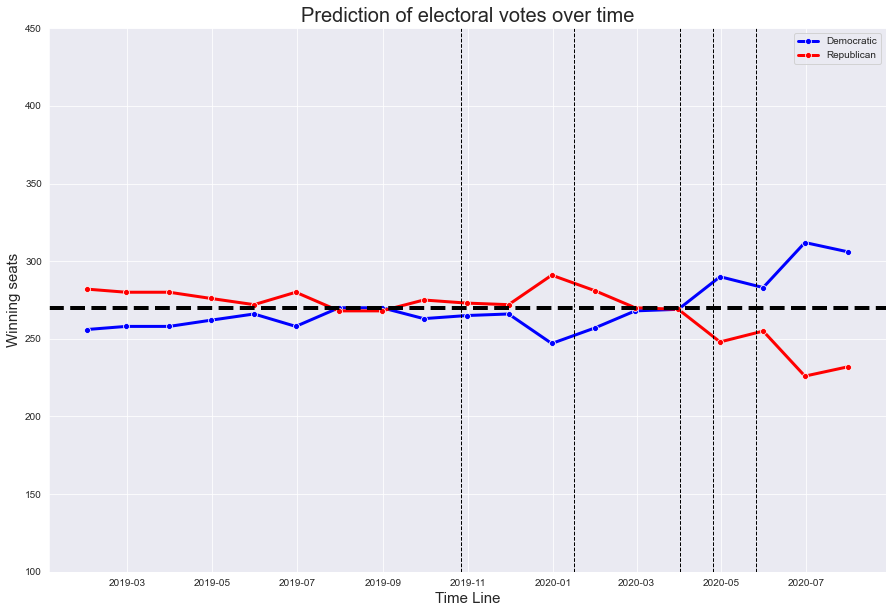

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize = (15,10)) 
ax = sns.lineplot(seat_df.index, seat_df['dem_mid'], color = 'blue', marker = 'o', linewidth = 3.0, label = 'Democratic')
# ax.fill_between(seat_df.index, seat_df['dem_low'], seat_df['dem_high'],\
#                 facecolor ='lightskyblue', alpha = 0.3) 
ax = sns.lineplot(seat_df.index, seat_df['rep_mid'], color = 'red', marker = 'o', linewidth = 3.0, label = 'Republican')
# ax.fill_between(seat_df.index, seat_df['rep_low'], seat_df['rep_high'],\
#                 facecolor ='lightsalmon', alpha = 0.3) 
plt.axhline(y = 270, color = 'black', linewidth=4.0, linestyle = '--')
for i, event in enumerate(events):
    plt.axvline(pd.to_datetime(event[0]), color = 'black', linewidth=1.0, linestyle = '--')
#     ax.annotate(event[1], (mdates.date2num(pd.to_datetime(event[0])), 350), xytext=(-150, 50*(-1)**i), 
#                 textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.set_title('Prediction of electoral votes over time', size=20)
ax.set_xlabel('Time Line', size = 15)
ax.set_ylabel('Winning seats', size=15)
ax.set_ylim(ymin=100, ymax = 450)





ax.legend()

In [20]:
dem_sure = dfs[-1][(dfs[-1].state_win_prob_dem >= 0.65) ].round(2)['ev'].sum()
rep_sure = dfs[-1][(dfs[-1].state_win_prob_dem <= 0.35) ].round(2)['ev'].sum()
tossup = dfs[-1][(dfs[-1].state_win_prob_dem > 0.35) & (dfs[-1].state_win_prob_dem < 0.65)].round(2)['ev'].sum()

In [21]:
print('Democratic Sure : ', dem_sure)
print('Republican Sure : ', rep_sure)
print('Tossup : ', tossup)

Democratic Sure :  188
Republican Sure :  108
Tossup :  242


In [22]:
prob_df = pd.DataFrame(probabilities, columns = ['dem', 'rep', 'tie', ]).round(4)*100
prob_df['dates'] = dates
prob_df = prob_df.set_index('dates')
prob_df

,dem,rep,tie
dates,,,
2019-01-31,37.30,61.90,0.80
2019-02-28,38.72,60.41,0.87
2019-03-31,36.86,62.22,0.92
2019-04-30,41.44,57.64,0.92
2019-05-31,45.80,53.15,1.05
2019-06-30,38.88,60.31,0.81
2019-07-31,49.72,49.50,0.78
2019-08-31,49.48,49.64,0.88
2019-09-30,43.13,56.15,0.72


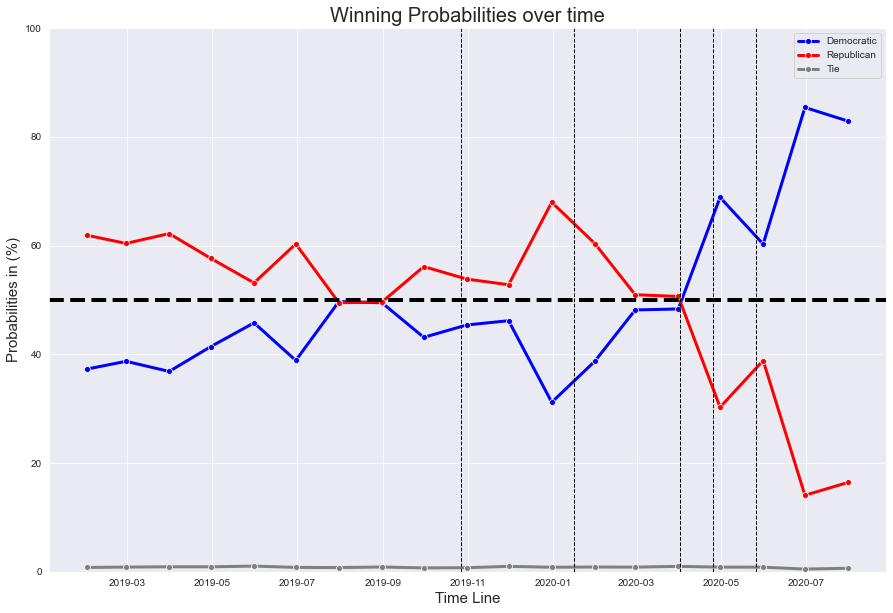

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (15,10)) 
ax = sns.lineplot(prob_df.index, prob_df['dem'], color = 'blue', marker = 'o', linewidth = 3.0, label = 'Democratic')
# ax.fill_between(prob_df.index, prob_df['dem_low'], prob_df['dem_high'],\
#                 facecolor ='lightskyblue', alpha = 0.3) 
ax = sns.lineplot(prob_df.index, prob_df['rep'], color = 'red', marker = 'o', linewidth = 3.0, label = 'Republican')
# ax.fill_between(prob_df.index, prob_df['rep_low'], prob_df['rep_high'],\
#                 facecolor ='lightsalmon', alpha = 0.3) 
ax = sns.lineplot(prob_df.index, prob_df['tie'], color = 'grey', marker = 'o', linewidth = 3.0, label = 'Tie')
plt.axhline(y = 50.0, color = 'black', linewidth=4.0, linestyle = '--')
for event in events:
    plt.axvline(pd.to_datetime(event[0]), color = 'black', linewidth=1.0, linestyle = '--')
ax.set_title('Winning Probabilities over time', size=20)
ax.set_xlabel('Time Line', size = 15)
ax.set_ylabel('Probabilities in (%)', size =15)
ax.set_ylim(ymin=0, ymax = 100)
ax.legend()

### Calculating state sentiment for last

In [82]:
df = pd.concat(dfs[-3:]).reset_index(drop=True).groupby(['state', 'state_abbr']).mean().reset_index()

In [83]:
pr, st = multiple_election(df)

100%|██████████| 10000/10000 [01:44<00:00, 96.01it/s]


In [84]:
print(pr)
print(st)

[0.7547, 0.2372, 0.0081]
[229.0, 300.0, 365.0, 173.0, 238.0, 309.0]


In [87]:
df['lean'] = df['state_win_prob_dem'].apply(lambda x : 'Strong Dem' if x >0.6 
                                            else ('Tossup' if x > 0.4 else 'Strong Rep'))
ev_stats = df.groupby('lean')['ev'].sum().reset_index().rename(columns = {'lean' : 'Lean'})
ev_stats = ev_stats.set_index('Lean').T[['Strong Dem', 'Tossup', 'Strong Rep']]

In [88]:
df

,state,state_abbr,dem_perc,rep_perc,moe,ev,state_win_count,winner,state_win_prob_dem,lean
0,Alabama,AL,0.420000,0.580000,0.046667,9,2467,rep,0.2467,Strong Rep
1,Alaska,AK,0.466667,0.533333,0.046667,3,3611,rep,0.3611,Strong Rep
2,Arizona,AZ,0.516667,0.483333,0.056667,11,4873,rep,0.4873,Tossup
3,Arkansas,AR,0.446667,0.553333,0.033333,6,2691,rep,0.2691,Strong Rep
4,California,CA,0.650000,0.350000,0.030000,55,9321,dem,0.9321,Strong Dem
5,Colorado,CO,0.576667,0.423333,0.053333,9,6264,dem,0.6264,Strong Dem
6,Connecticut,CT,0.630000,0.370000,0.023333,7,9264,dem,0.9264,Strong Dem
7,Delaware,DE,0.530000,0.470000,0.023333,3,5416,rep,0.5416,Tossup
8,District of Columbia,DC,0.960000,0.040000,0.023333,3,10000,dem,1.0000,Strong Dem
9,Florida,FL,0.526667,0.473333,0.040000,29,5136,rep,0.5136,Tossup


In [89]:
# import plotly.graph_objects as go

# fig = go.Figure(go.Scattergeo())
# fig.update_geos(
#     visible=False, resolution=110, scope="usa",
#     showcountries=True, countrycolor="Black",
#     showsubunits=True, subunitcolor="Blue"
# )
# fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

# color pallette
# strong_rep = '#FF0000' # confirmed - grey
# dth = '#ff2e63' # death - red
# rec = '#21bf73' # recovered - cyan
# act = '#fe9801' # active case - yellow



import plotly.express as px  # Be sure to import express



fig = px.choropleth(df,  # Input Pandas DataFrame
                    locations="state_abbr",  # DataFrame column with locations
                    color='lean',  # DataFrame column with color values
                    hover_name="state",
                    color_discrete_sequence = ['#0000FF',  '#808080',  '#FF0000'], 
                    category_orders={"lean": ["Strong Dem", "Tossup", "Strong Rep"]},
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = ' Predicted Electotal Map ', # Create a Title
    geo_scope='usa',  # Plot only the USA instead of globe
)
fig.show()  # Output the plot to the screen

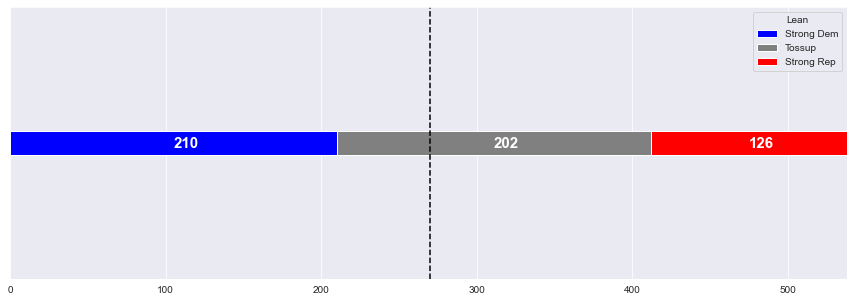

In [90]:
fig,ax = plt.subplots(figsize = (15,5))
ev_stats.plot.barh(stacked=True, ax=ax, width = 0.05, color = ['blue', 'grey', 'red'])
plt.axvline(x=270, color = 'black', linestyle = '--')
plt.xlim(xmax = 538)
bottom = 0
plt.ylabel('Electotal Votes')
ax.axes.get_yaxis().set_visible(False)
for i, v in enumerate(ev_stats.values[0]):
    ax.text(v/2 + bottom, -0.009, str(v), color='white', fontweight='bold', size = 15)
    bottom += v

In [91]:
df

,state,state_abbr,dem_perc,rep_perc,moe,ev,state_win_count,winner,state_win_prob_dem,lean
0,Alabama,AL,0.420000,0.580000,0.046667,9,2467,rep,0.2467,Strong Rep
1,Alaska,AK,0.466667,0.533333,0.046667,3,3611,rep,0.3611,Strong Rep
2,Arizona,AZ,0.516667,0.483333,0.056667,11,4873,rep,0.4873,Tossup
3,Arkansas,AR,0.446667,0.553333,0.033333,6,2691,rep,0.2691,Strong Rep
4,California,CA,0.650000,0.350000,0.030000,55,9321,dem,0.9321,Strong Dem
5,Colorado,CO,0.576667,0.423333,0.053333,9,6264,dem,0.6264,Strong Dem
6,Connecticut,CT,0.630000,0.370000,0.023333,7,9264,dem,0.9264,Strong Dem
7,Delaware,DE,0.530000,0.470000,0.023333,3,5416,rep,0.5416,Tossup
8,District of Columbia,DC,0.960000,0.040000,0.023333,3,10000,dem,1.0000,Strong Dem
9,Florida,FL,0.526667,0.473333,0.040000,29,5136,rep,0.5136,Tossup


In [92]:
lean_states = {}

for index, row in df.iterrows():
    if row['lean'] in lean_states.keys():
        lean_states[row['lean']].append([row['state'], row['state_win_prob_dem']])
    else:
        lean_states[row['lean']] = [[row['state'], row['state_win_prob_dem']]]

In [93]:
lean_states

{'Strong Rep': [['Alabama', 0.2467],
  ['Alaska', 0.3611],
  ['Arkansas', 0.2691],
  ['Idaho', 0.0],
  ['Indiana', 0.23],
  ['Kansas', 0.2177],
  ['Kentucky', 0.212],
  ['Louisiana', 0.041],
  ['Mississippi', 0.292],
  ['Missouri', 0.3982],
  ['Montana', 0.3223],
  ['Nebraska', 0.0],
  ['North Dakota', 0.0],
  ['Oklahoma', 0.1211],
  ['South Carolina', 0.338],
  ['South Dakota', 0.0],
  ['Tennessee', 0.262],
  ['Utah', 0.2909],
  ['West Virginia', 0.0],
  ['Wyoming', 0.0]],
 'Tossup': [['Arizona', 0.4873],
  ['Delaware', 0.5416],
  ['Florida', 0.5136],
  ['Georgia', 0.4448],
  ['Iowa', 0.4405],
  ['Michigan', 0.5711],
  ['Minnesota', 0.5637],
  ['Nevada', 0.5073],
  ['New Hampshire', 0.5459],
  ['North Carolina', 0.4769],
  ['Ohio', 0.451],
  ['Pennsylvania', 0.5056],
  ['Texas', 0.4293],
  ['Wisconsin', 0.5306]],
 'Strong Dem': [['California', 0.9321],
  ['Colorado', 0.6264],
  ['Connecticut', 0.9264],
  ['District of Columbia', 1.0],
  ['Hawaii', 1.0],
  ['Illinois', 0.7646],
  ['Mai

In [99]:
lean_dfs = []
for k,v in lean_states.items():
    df = pd.DataFrame(lean_states[k], columns = ['State', 'Democratic Probabilities']).round(2).set_index(
        'State').style.format("{:.0%}", na_rep="-")

    lean_dfs.append(df)
    
    

In [100]:
with pd.option_context('display.precision', 2):
    html = (lean_dfs[0].set_properties(**{'background-color': 'lightsalmon',
                           'color': 'black',
                           'border-color': 'white'}))
html

,Democratic Probabilities
State,
Alabama,25%
Alaska,36%
Arkansas,27%
Idaho,0%
Indiana,23%
Kansas,22%
Kentucky,21%
Louisiana,4%
Mississippi,29%


In [102]:
with pd.option_context('display.precision', 2):
    html = (lean_dfs[1].set_properties(**{'background-color': 'lightcyan',
                           'color': 'black',
                           'border-color': 'white',
                                         'fontweight' : 'bold'}))
html

,Democratic Probabilities
State,
Arizona,49%
Delaware,54%
Florida,51%
Georgia,44%
Iowa,44%
Michigan,57%
Minnesota,56%
Nevada,51%
New Hampshire,55%


In [29]:
df = dfs[0]

In [30]:
demo = pd.read_csv('../data/processed/demographics2020.csv', usecols=['state', 'kmeans_labels'])

In [31]:
df = df.merge(demo, on='state')


In [32]:
df.head()

,start_date,state,dem_perc,rep_perc,moe,state_abbr,ev,state_win_count,winner,state_win_prob_dem,kmeans_labels
0,2019-01-31,Alabama,0.36,0.64,0.05,AL,9,1228,rep,0.1228,4
1,2019-01-31,Alaska,0.42,0.58,0.05,AK,3,2574,rep,0.2574,5
2,2019-01-31,Arizona,0.48,0.52,0.05,AZ,11,3981,dem,0.3981,0
3,2019-01-31,Arkansas,0.36,0.64,0.05,AR,6,1113,rep,0.1113,0
4,2019-01-31,California,0.66,0.34,0.05,CA,55,8402,dem,0.8402,2


In [33]:

kmeans_groups = df.groupby("kmeans_labels")

In [34]:
group = kmeans_groups.get_group(list(kmeans_groups.groups.keys())[2])

In [35]:
group

,start_date,state,dem_perc,rep_perc,moe,state_abbr,ev,state_win_count,winner,state_win_prob_dem,kmeans_labels
4,2019-01-31,California,0.66,0.34,0.05,CA,55,8402,dem,0.8402,2
9,2019-01-31,Florida,0.49,0.51,0.05,FL,29,4269,dem,0.4269,2
32,2019-01-31,New York,0.63,0.37,0.05,NY,29,7552,rep,0.7552,2
43,2019-01-31,Texas,0.43,0.57,0.07,TX,38,3401,rep,0.3401,2
